# Preliminaries

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [58]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

warnings.filterwarnings('ignore')

In [59]:
path = "../Datasets/"
Train = pd.read_csv(path + '/Historical-transaction-data.csv')
StoreInfo = pd.read_csv(path + '/Store-info.csv')
Testing = pd.read_csv(path + '/Testing-data.csv')

In [60]:
Train = Train.merge(StoreInfo, on='shop_id', how='left')

In [61]:
Testing.drop("shop_profile", axis=1, inplace=True)


In [62]:
Submission_testing = Testing.copy()
Submission_testing = Submission_testing.merge(Train, on='shop_id', how='left')

In [63]:
Submission_testing.drop("shop_profile", axis=1, inplace=True)

In [64]:
# Train.to_csv('CombinedData.csv', index=False)
# Submission_testing.to_csv('SubmissionData.csv', index=False)

In [65]:
redundant_cols = ['customer_id', 'transaction_date']

Train.drop(redundant_cols, axis=1, inplace=True)
Submission_testing.drop(redundant_cols, axis=1, inplace=True)

In [66]:
features_nom = ['item_description',"shop_id", "shop_profile", "invoice_id"]

for feature in features_nom:
    Train[feature] = Train[feature].astype("category")
    if feature == "shop_profile":
        continue
    Submission_testing[feature] = Submission_testing[feature].astype("category")

# Preprocessing

In [67]:
Train["shop_id"] = Train["shop_id"].str.replace("SHOP", "").astype(int).astype("category")
Submission_testing["shop_id"] = Submission_testing["shop_id"].str.replace("SHOP", "").astype(int).astype("category")
StoreInfo["shop_id"] = StoreInfo["shop_id"].str.replace("SHOP", "").astype(int).astype("category")

In [68]:
#Remove rows with null values for item_description or shop_profile
Train = Train.dropna(subset=['shop_profile'], axis=0)

In [69]:
from sklearn.compose import ColumnTransformer
#import simpleimputer
from sklearn.impute import SimpleImputer

Submission_testing['shop_profile'] = 'default_value'
ct = ColumnTransformer([("SimpleImputer", SimpleImputer(strategy="constant", fill_value="missing"), ["item_description"])], remainder="passthrough")

Train = pd.DataFrame(ct.fit_transform(Train), columns=Train.columns)

Submission_testing = pd.DataFrame(ct.transform(Submission_testing), columns=Train.columns)

In [70]:
# Replace values in the "item_description" column of the Train dataframe
Train['item_description'] = Train['item_description'].str.lower()
Train.loc[Train['item_description'].str.contains('milk', case=False), 'item_description'] = 'MILK'
Train.loc[Train['item_description'].str.contains('water', case=False), 'item_description'] = 'WATER'
Train.loc[Train['item_description'].str.contains('missing', case=False), 'item_description'] = 'MISSING'
Train.loc[~Train['item_description'].str.contains('MILK|WATER|MISSING', case=False), 'item_description'] = 'DRINK'

# Replace values in the "item_description" column of the Submission_testing dataframe
Submission_testing['item_description'] = Submission_testing['item_description'].str.lower()
Submission_testing.loc[Submission_testing['item_description'].str.contains('milk', case=False), 'item_description'] = 'MILK'
Submission_testing.loc[Submission_testing['item_description'].str.contains('water', case=False), 'item_description'] = 'WATER'
Submission_testing.loc[Submission_testing['item_description'].str.contains('missing', case=False), 'item_description'] = 'MISSING'
Submission_testing.loc[~Submission_testing['item_description'].str.contains('MILK|WATER|MISSING', case=False), 'item_description'] = 'DRINK'

In [71]:
Train.drop_duplicates(inplace=True)
Submission_testing.drop_duplicates(inplace=True)

In [72]:
# drop invoice_id column from both dataframes
Train.drop("invoice_id", axis=1, inplace=True)
Submission_testing.drop(["invoice_id", "shop_profile"], axis=1, inplace=True)

In [73]:
category_columns = ["shop_id", "item_description", "shop_profile"]

for col in Train.columns:
    if col not in category_columns:
        Train[col] = Train[col].astype("int64")
        Submission_testing[col] = Submission_testing[col].astype("int64")
    else:
        Train[col] = Train[col].astype("category")
        if col == "shop_profile":
            continue
        Submission_testing[col] = Submission_testing[col].astype("category")

In [74]:
# suppose x1 and x3 column should have a minimum of zero, define the acceptable ranges for each column

ranges = {'quantity_sold': (0, np.inf)}

# loop over each column and adjust the values outside the acceptable range

for col, (min_val, max_val) in ranges.items():
    Train[col] = np.clip(Train[col], min_val, max_val)
    Submission_testing[col] = np.clip(Submission_testing[col], min_val, max_val)

In [75]:
def outlier_thresholds(dataframe, column_name, q1=0.05, q2=0.95):
    quartile1 = dataframe[column_name].quantile(0.05)
    quartile3 = dataframe[column_name].quantile(0.95)
    IQR = quartile3 - quartile1
    up_limit = quartile3 + 1.5*IQR
    low_limit = quartile1 - 1.5*IQR
    return low_limit, up_limit

def check_outlier(dataframe, column_name):
    low_limit, up_limit = outlier_thresholds(dataframe, column_name)
    if dataframe[(dataframe[column_name] < low_limit) | (dataframe[column_name] > up_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_thresholds(dataframe, column_name):
    low_limit, up_limit = outlier_thresholds(dataframe, column_name)
    dataframe.loc[(dataframe[column_name] < low_limit), column_name] = low_limit
    dataframe.loc[(dataframe[column_name] > up_limit), column_name] = up_limit
    
def remove_outliers(df):
    numeric_columns = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    for col in numeric_columns:
        print(col, check_outlier(df, col))
        if check_outlier(df, col):
            replace_with_thresholds(df, col)

In [76]:
Train.kurt(numeric_only=True)

item_price         363.995483
quantity_sold      374.858178
shop_area_sq_ft      2.973588
dtype: float64

In [77]:
Train.describe()

,item_price,quantity_sold,shop_area_sq_ft
count,351762.000000,351762.000000,351762.000000
mean,209.261958,1.945378,632.962836
std,169.497265,1.667743,123.672885
min,35.000000,0.000000,298.000000
25%,100.000000,1.000000,605.000000
50%,220.000000,2.000000,617.000000
75%,220.000000,2.000000,676.000000
max,17400.000000,101.000000,1077.000000


In [78]:
# remove_outliers(Train)
# remove_outliers(Submission_testing)

In [79]:
Train.kurt(numeric_only=True)

item_price         363.995483
quantity_sold      374.858178
shop_area_sq_ft      2.973588
dtype: float64

In [80]:
Train.describe()

,item_price,quantity_sold,shop_area_sq_ft
count,351762.000000,351762.000000,351762.000000
mean,209.261958,1.945378,632.962836
std,169.497265,1.667743,123.672885
min,35.000000,0.000000,298.000000
25%,100.000000,1.000000,605.000000
50%,220.000000,2.000000,617.000000
75%,220.000000,2.000000,676.000000
max,17400.000000,101.000000,1077.000000


In [81]:
# Create price-related features
Train['total_sales']= Train['item_price'] * Train['quantity_sold']
Submission_testing['total_sales']= Submission_testing['item_price'] * Submission_testing['quantity_sold']

In [82]:
# frequency encode the item_description column

item_description_freq = Train.groupby('item_description').size()/len(Train)
# mapping the encoded values to the Train and Submission_testing dataframes
Train['item_description_freq'] = Train['item_description'].map(item_description_freq)
Submission_testing['item_description_freq'] = Submission_testing['item_description'].map(item_description_freq)

In [83]:
# drop the item_description column and month column from both dataframes
Train.drop(["item_description"], axis=1, inplace=True)
Submission_testing.drop(["item_description"], axis=1, inplace=True)

In [84]:
Train.head(100)

,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,total_sales,item_description_freq
0,8,220,2,678,Moderate,440,0.846726
1,112,220,2,668,Moderate,440,0.846726
2,8,160,2,678,Moderate,320,0.846726
3,8,150,2,678,Moderate,300,0.846726
4,112,210,5,668,Moderate,1050,0.012887
...,...,...,...,...,...,...,...
109,90,70,1,730,Moderate,70,0.082001
111,47,60,1,528,Moderate,60,0.846726
112,47,220,2,528,Moderate,440,0.846726
113,22,60,2,735,High,120,0.846726


In [85]:
# create a new feature for the fraction of  entries by each shop_id
train_shop_id_counts = Train['shop_id'].value_counts(normalize=True)
Train['shop_id_counts'] = Train['shop_id'].map(train_shop_id_counts)

submit_shop_id_counts = Submission_testing['shop_id'].value_counts(normalize=True)
Submission_testing['shop_id_counts'] = Submission_testing['shop_id'].map(submit_shop_id_counts)

In [86]:
# create a feature for the mean item_price by each shop_id

train_shop_price_mean = Train.groupby('shop_id')['item_price'].mean()
Train['shop_price_mean'] = Train['shop_id'].map(train_shop_price_mean)

submit_shop_price_mean = Submission_testing.groupby('shop_id')['item_price'].mean()
Submission_testing['shop_price_mean'] = Submission_testing['shop_id'].map(submit_shop_price_mean)

In [87]:
Train.to_csv("TrainPP.csv", index=False)
Submission_testing.to_csv("Submission_testingPP.csv", index=False)

# Aggregation

In [88]:
Train.head()

,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,total_sales,item_description_freq,shop_id_counts,shop_price_mean
0,8,220,2,678,Moderate,440,0.846726,0.000685,211.286307
1,112,220,2,668,Moderate,440,0.846726,0.006249,205.996360
2,8,160,2,678,Moderate,320,0.846726,0.000685,211.286307
3,8,150,2,678,Moderate,300,0.846726,0.000685,211.286307
4,112,210,5,668,Moderate,1050,0.012887,0.006249,205.996360


In [89]:
# Aggregate X_train_scaled by shop_id and add all the total_sales values and prevent empty values
# Also get the mode  of the item_description_freq column

Train["item_description_freq"] = Train["item_description_freq"].astype("float64")
Submission_testing["item_description_freq"] = Submission_testing["item_description_freq"].astype("float64")

Train["item_description_freq"] = Train["item_description_freq"].astype("float64")
Submission_testing["item_description_freq"] = Submission_testing["item_description_freq"].astype("float64")

# mode is useless as it is same for all the rows
Train_cum = Train.groupby(['shop_id'], sort=False).agg({'total_sales':'sum', 'item_description_freq':'mean'})
Submission_testing_cum = Submission_testing.groupby(['shop_id'], sort='False').agg({'total_sales':'sum', 'item_description_freq':'mean'})

In [90]:
Train_cum.head()

,total_sales,item_description_freq
shop_id,,
8,122895,0.764508
112,1135920,0.746056
55,882065,0.733008
3,1799705,0.739184
71,877060,0.693795


In [91]:

Train_cum = Train_cum.merge(StoreInfo, on='shop_id', how='left')
Train_cum['shop_id_counts'] = Train_cum['shop_id'].map(train_shop_id_counts)
Train_cum['shop_id_counts'] = Train_cum['shop_id_counts'].astype("float64")
Train_cum['shop_price_mean'] = Train_cum['shop_id'].map(train_shop_price_mean)
Train_cum['shop_price_mean'] = Train_cum['shop_price_mean'].astype("float64")

Submission_testing_cum = Submission_testing_cum.merge(StoreInfo, on='shop_id', how='left')
Submission_testing_cum['shop_id_counts'] = Submission_testing_cum['shop_id'].map(submit_shop_id_counts)
Submission_testing_cum['shop_id_counts'] = Submission_testing_cum['shop_id_counts'].astype("float64")
Submission_testing_cum['shop_price_mean'] = Submission_testing_cum['shop_id'].map(submit_shop_price_mean)
Submission_testing_cum['shop_price_mean'] = Submission_testing_cum['shop_price_mean'].astype("float64")
Submission_testing_cum.drop(["shop_profile"], axis=1, inplace=True)

In [92]:
# new feature: total_sales per sq ft of the shop
Train_cum['sales_per_sq_ft'] = Train_cum['total_sales'] / Train_cum['shop_area_sq_ft']
Submission_testing_cum['sales_per_sq_ft'] = Submission_testing_cum['total_sales'] / Submission_testing_cum['shop_area_sq_ft']

# new feature : multiplication of the total_sales and total_sales_per_sq_ft
Train_cum['sales_times_shop_area'] = Train_cum['total_sales'] * Train_cum['shop_area_sq_ft']
Submission_testing_cum['sales_times_shop_area'] = Submission_testing_cum['total_sales'] * Submission_testing_cum['shop_area_sq_ft']

In [93]:
Train_cum.describe()

,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,sales_per_sq_ft,sales_times_shop_area
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,2.033379e+06,0.727512,628.290000,0.010000,209.540782,3366.357722,1.289316e+09
std,8.047619e+05,0.029402,128.999201,0.002957,16.235592,1539.208762,6.256146e+08
min,1.228950e+05,0.572841,298.000000,0.000685,150.809524,181.261062,8.332281e+07
25%,1.530981e+06,0.714207,573.250000,0.008229,198.617831,2506.793736,8.558116e+08
50%,1.894988e+06,0.730701,617.000000,0.009909,208.462770,3100.256462,1.191022e+09
75%,2.518536e+06,0.746506,676.000000,0.011676,218.735418,4095.282824,1.574806e+09
max,5.784905e+06,0.777821,1077.000000,0.017029,262.783737,10745.973154,3.868988e+09


In [94]:
Submission_testing_cum.describe()

,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,sales_per_sq_ft,sales_times_shop_area
count,2.400000e+01,24.000000,24.000000,24.000000,24.000000,24.000000,2.400000e+01
mean,2.055834e+06,0.731226,585.416667,0.041667,218.990978,3707.221150,1.194978e+09
std,5.625499e+05,0.034623,112.998236,0.010790,14.550969,1497.527004,3.799535e+08
min,1.072345e+06,0.629791,310.000000,0.022716,196.347483,1753.930070,5.618021e+08
25%,1.724305e+06,0.715052,529.250000,0.035316,210.146030,2804.086701,8.704153e+08
50%,2.079385e+06,0.736972,607.000000,0.042703,218.763786,3488.224276,1.238438e+09
75%,2.481351e+06,0.752665,676.000000,0.046677,230.035006,4625.959857,1.490490e+09
max,2.936345e+06,0.779407,774.000000,0.065425,243.600829,8247.129032,1.870452e+09


In [95]:
y_train_main = Train_cum["shop_profile"]
Train_cum.drop("shop_profile", axis=1, inplace=True)

# Feature Scaling

In [96]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler

scaled_columns = ["total_sales", "shop_area_sq_ft", "shop_id_counts", "shop_price_mean", "sales_per_sq_ft", "sales_times_shop_area"]
ct = ColumnTransformer([("StandardScaler", StandardScaler(), scaled_columns)], remainder="passthrough")

# scaled_columns = ["total_sales", "shop_area_sq_ft", "shop_id_counts", "shop_price_mean", "sales_per_sq_ft", "sales_times_shop_area"]
# ct = ColumnTransformer([("MinMaxScaler", MinMaxScaler(feature_range=(0, 100)), scaled_columns)], remainder="passthrough")

# Fit and transform only the scaled columns in the training data
scaled_X_train = Train_cum.copy()
scaled_X_train[scaled_columns] = ct.fit_transform(Train_cum[scaled_columns])

# Transform only the scaled columns in the submission testing data
scaled_X_submission = Submission_testing_cum.copy()
scaled_X_submission[scaled_columns] = ct.transform(Submission_testing_cum[scaled_columns])

In [97]:
scaled_X_train.head()

,shop_id,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,sales_per_sq_ft,sales_times_shop_area
0,8,-2.385933,0.764508,0.387293,-3.165694,0.108054,-2.079733,-1.937405
1,112,-1.120803,0.746056,0.309382,-1.274946,-0.219412,-1.087748,-0.852273
2,55,-1.437834,0.733008,0.714516,-1.235334,-1.075963,-1.398157,-1.051007
3,3,-0.291826,0.739184,1.415710,-0.162912,0.302270,-0.747310,0.270603
4,71,-1.444084,0.693795,0.589860,-1.220842,-1.386919,-1.384618,-1.079340


In [98]:
# set scaled_X_train shop_id as categorical and other columns as numerical

category_columns = ["shop_id"]

for column in category_columns:
    scaled_X_train[column] = scaled_X_train[column].astype("category")
    scaled_X_submission[column] = scaled_X_submission[column].astype("category")

In [99]:
scaled_X_train.describe()

,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,sales_per_sq_ft,sales_times_shop_area
count,1.000000e+02,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,-6.217249e-17,0.727512,2.745026e-16,-6.250556e-16,-1.076916e-15,1.876277e-16,7.882583e-17
std,1.005038e+00,0.029402,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00
min,-2.385933e+00,0.572841,-2.573302e+00,-3.165694e+00,-3.635663e+00,-2.079733e+00,-1.937405e+00
25%,-6.274257e-01,0.714207,-4.288188e-01,-6.017835e-01,-6.761674e-01,-5.612587e-01,-6.964170e-01
50%,-1.728315e-01,0.730701,-8.796083e-02,-3.103262e-02,-6.673252e-02,-1.737528e-01,-1.579080e-01
75%,6.058958e-01,0.746506,3.717105e-01,5.694273e-01,5.691790e-01,4.759571e-01,4.586340e-01
max,4.685145e+00,0.777821,3.495917e+00,2.388681e+00,3.295918e+00,4.818575e+00,4.144192e+00


In [100]:
scaled_X_submission.describe()

,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,sales_per_sq_ft,sales_times_shop_area
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.028044,0.731226,-0.334028,10.762029,0.584999,0.222569,-0.151552
std,0.702548,0.034623,0.880374,3.666909,0.900754,0.977821,0.610388
min,-1.200200,0.629791,-2.479810,4.321612,-0.816710,-1.052847,-1.168738
25%,-0.385991,0.715052,-0.771625,8.603680,0.037467,-0.367139,-0.672956
50%,0.057456,0.736972,-0.165871,11.114227,0.570935,0.079574,-0.081735
75%,0.559457,0.752665,0.371710,12.464824,1.268662,0.822467,0.323181
max,1.127682,0.779407,1.135232,18.836516,2.108432,3.186936,0.933583


In [101]:
# scaled_X_train.to_csv("scaled_X_train.csv", index=False)
# scaled_X_submission.to_csv("scaled_X_submission.csv", index=False)

In [102]:
scaled_X_train.head()

,shop_id,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,sales_per_sq_ft,sales_times_shop_area
0,8,-2.385933,0.764508,0.387293,-3.165694,0.108054,-2.079733,-1.937405
1,112,-1.120803,0.746056,0.309382,-1.274946,-0.219412,-1.087748,-0.852273
2,55,-1.437834,0.733008,0.714516,-1.235334,-1.075963,-1.398157,-1.051007
3,3,-0.291826,0.739184,1.415710,-0.162912,0.302270,-0.747310,0.270603
4,71,-1.444084,0.693795,0.589860,-1.220842,-1.386919,-1.384618,-1.079340


# Train Test Split

In [103]:
## Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X_train, y_train_main, test_size = 0.2, random_state = 1)

In [104]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_train_main = le.transform(y_train_main)

In [105]:
# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)

# Metrics

In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder

def score_classification(model, df1_x, df1_y, df2_x, df2_y):
  print(model)
  df1_x = df1_x.copy()
  df2_x = df2_x.copy() 
  ct2 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [0])], remainder='passthrough')

  # One hot encoding for the item_description column

  df1_encoded = ct2.fit_transform(df1_x[["shop_id"]])
  df1_x = pd.concat([df1_x.drop("shop_id", axis=1).reset_index(drop=True), pd.DataFrame(df1_encoded.toarray())], axis='columns')

  df2_encoded = ct2.transform(df2_x[["shop_id"]])
  df2_x = pd.concat([df2_x.drop("shop_id", axis=1).reset_index(drop=True), pd.DataFrame(df2_encoded.toarray())], axis='columns')

  # remove the dummy variable trap
  df1_x = df1_x.drop([0], axis=1)
  df2_x = df2_x.drop([0], axis=1)
  
  df1_x.columns = df1_x.columns.astype(str)
  df2_x.columns = df2_x.columns.astype(str)
  # Fit the model  
  model.fit(df1_x, df1_y)

  # Make predictions
  y_pred = model.predict(df2_x)

  # Evaluate the model
  accuracy = accuracy_score(df2_y, y_pred)
  precision = precision_score(df2_y, y_pred,  average='macro')
  recall = recall_score(df2_y, y_pred,  average='macro')
  f1 = f1_score(df2_y, y_pred,  average='macro')

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")

In [107]:
def outputResult(model, df1_x, df1_y, test, le):
    print(model)
    df1_x = df1_x.copy()
    df2_x = test.copy()
    
    ct2 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [0])], remainder='passthrough')

    # One hot encoding for the item_description column

    df1_encoded = ct2.fit_transform(df1_x[["shop_id"]])
    df1_x = pd.concat([df1_x.drop("shop_id", axis=1).reset_index(drop=True), pd.DataFrame(df1_encoded.toarray())], axis='columns')

    df2_encoded = ct2.transform(df2_x[["shop_id"]])
    df2_x = pd.concat([df2_x.drop("shop_id", axis=1).reset_index(drop=True), pd.DataFrame(df2_encoded.toarray())], axis='columns')

  # Drop the first column to avoid dummy variable trap
    df1_x = df1_x.drop([0], axis=1)
    df2_x = df2_x.drop([0], axis=1)

    df1_x.columns = df1_x.columns.astype(str)
    df2_x.columns = df2_x.columns.astype(str)
    # Fit the model on the training data
    model.fit(df1_x, df1_y)
    
    # Make predictions on the test data
    y_pred = model.predict(df2_x)
    
    # Inverse transform the encoded predictions to the original shop profiles
    y_pred = le.inverse_transform(y_pred)    
    
    # Create a dataframe with the predicted shop profiles
    results_df = pd.DataFrame({'shop_id': test.shop_id, 'shop_profile': y_pred})    
    # rename the shop_id column with the word "SHOP" and add a 0 in front of the shop_id
    results_df["shop_id"] = results_df["shop_id"].astype(int).astype(str)
    results_df["shop_id"] = "SHOP" + results_df["shop_id"].str.zfill(3)
    # results_df.to_csv('predictions'+str(model).strip("()")+'.csv', index=False)

    # results_df.drop_duplicates(inplace=True)
    
    # Access the global testing dataframe
    results_final = pd.merge(Testing, results_df, on="shop_id", how="left")
    # Write the dataframe to a CSV file
    results_final.to_csv('predictions'+str(model).strip("()")+'.csv', index=False)

# Modelling

In [52]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression()

In [118]:
score_classification(logr, X_train, y_train, X_test, y_test)

LogisticRegression()
Accuracy: 0.55
Precision: 0.5277777777777778
Recall: 0.515151515151515
F1 Score: 0.5068226120857701


In [119]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

In [127]:
score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 0.3
Precision: 0.34656084656084657
Recall: 0.3131313131313131
F1 Score: 0.3


In [56]:
outputResult(dtc, scaled_X_train, y_train_main, scaled_X_submission, le)

DecisionTreeClassifier()


In [128]:
# import svm

from sklearn import svm

svm = svm.SVC()

score_classification(svm, X_train, y_train, X_test, y_test)

SVC()
Accuracy: 0.55
Precision: 0.49404761904761907
Recall: 0.4595959595959596
F1 Score: 0.4603174603174603


In [129]:
score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 0.2
Precision: 0.24444444444444446
Recall: 0.1717171717171717
F1 Score: 0.19444444444444445


In [130]:

score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 0.35
Precision: 0.38359788359788355
Recall: 0.42424242424242414
F1 Score: 0.35555555555555557


In [131]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier()

In [132]:
score_classification(rfc, X_train, y_train, X_test, y_test)

RandomForestClassifier()
Accuracy: 0.3
Precision: 0.3333333333333333
Recall: 0.3080808080808081
F1 Score: 0.25961538461538464


In [133]:
# Define the hyperparameters to test
rfc_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [134]:

# # Use grid search cross-validation to find the best hyperparameters
# rfc_grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)
# rfc_grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and the corresponding accuracy score
# print("Best Hyperparameters: ", rfc_grid_search.best_params_)
# print("Best Accuracy Score: ", rfc_grid_search.best_score_)


In [135]:
rfc.set_params(max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10)

In [136]:
score_classification(rfc, X_train, y_train, X_test, y_test)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10)
Accuracy: 0.3
Precision: 0.19999999999999998
Recall: 0.3888888888888889
F1 Score: 0.25961538461538464


In [137]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1)

In [138]:
score_classification(svm, X_train, y_train, X_test, y_test)

SVC(C=1, kernel='linear')
Accuracy: 0.55
Precision: 0.44973544973544977
Recall: 0.4343434343434343
F1 Score: 0.43846153846153846


In [139]:
outputResult(logr, scaled_X_train, y_train_main, scaled_X_submission, le)

LogisticRegression()


In [140]:
X_train.head()

,shop_id,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,sales_per_sq_ft,sales_times_shop_area
2,55,-1.437834,0.733008,0.714516,-1.235334,-1.075963,-1.398157,-1.051007
73,9,-0.241329,0.693988,0.371710,0.604209,-1.095486,-0.420672,-0.072905
97,126,-0.304165,0.728389,-2.339571,-0.494300,-0.240830,1.364959,-1.128157
62,118,0.864983,0.743282,-0.087961,0.982938,0.406399,0.686772,0.630741
19,75,-0.002939,0.723411,0.628815,0.787776,-1.332361,-0.327605,0.242065


In [141]:
scaled_X_submission.head()

,shop_id,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,sales_per_sq_ft,sales_times_shop_area
0,2,1.127682,0.749145,0.067860,15.434853,1.488775,0.811815,0.933583
1,19,0.124201,0.771123,-1.692915,11.553359,2.058911,1.190348,-0.663032
2,23,0.537506,0.739770,-0.087961,12.615843,0.890735,0.409270,0.370828
3,24,-0.976266,0.704736,0.371710,7.954622,-0.585818,-0.989098,-0.711988
4,29,-0.221284,0.722005,-0.243782,11.403411,0.153667,-0.167916,-0.291048


In [142]:
outputResult(dtc, X_train, y_train, scaled_X_submission, le)

DecisionTreeClassifier()


In [143]:
# Define the parameter grid for hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'degree': [2, 3, 4, 5]}


# Initialize the SVM model
svm = SVC()

In [144]:

# # # Use grid search cross-validation to find the best hyperparameters
# svm_grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1)
# svm_grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and the corresponding accuracy score
# print("Best Hyperparameters: ", svm_grid_search.best_params_)
# print("Best Accuracy Score: ", svm_grid_search.best_score_)

In [145]:
svm.set_params(C=1, gamma=0.1, kernel='linear')

SVC(C=1, gamma=0.1, kernel='linear')

In [146]:
score_classification(svm, X_train, y_train, X_test, y_test)

SVC(C=1, gamma=0.1, kernel='linear')
Accuracy: 0.55
Precision: 0.44973544973544977
Recall: 0.4343434343434343
F1 Score: 0.43846153846153846


In [147]:
from sklearn.ensemble import GradientBoostingClassifier

In [148]:
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1)

In [149]:
score_classification(gbm, X_train, y_train, X_test, y_test)

GradientBoostingClassifier(random_state=1)
Accuracy: 0.45
Precision: 0.5388888888888889
Recall: 0.5353535353535354
F1 Score: 0.4581196581196581


In [150]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [151]:
score_classification(knn, X_train, y_train, X_test, y_test)

KNeighborsClassifier()
Accuracy: 0.55
Precision: 0.5
Recall: 0.4343434343434343
F1 Score: 0.4646464646464646


In [152]:
from sklearn.pipeline import Pipeline
import numpy as np

# Define the parameter grid to search over
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10, 20, 30, 40, 50],
    'knn__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

# Create a pipeline to preprocess the data and apply KNN
knn_pipeline = Pipeline([ 
    ('knn', KNeighborsClassifier())
])

# Create a grid search object to find the best parameters
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, n_jobs=-1)

In [153]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False).split(range(25))

from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1_macro')
print(scores)

[0.3952381  0.51111111 0.3        0.37777778 0.22222222 0.22222222
 0.0952381  0.08333333 0.45714286 0.5       ]


In [154]:
# Fit the grid search object on the data
# knn_grid_search.fit(X_train, y_train)

# # Print the best parameters found
# print("Best parameters:", knn_grid_search.best_params_)


In [155]:
# Set the best parameters found by GridSearchCV
knn.set_params(**{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'})

score_classification(knn, X_train, y_train, X_test, y_test)

KNeighborsClassifier(leaf_size=10, metric='manhattan', n_neighbors=11, p=1,
                     weights='distance')
Accuracy: 0.45
Precision: 0.4797619047619048
Recall: 0.4797979797979797
F1 Score: 0.442016317016317


In [156]:
scores = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy')
print(scores)

[0.5   0.5   0.5   0.625 0.375 0.75  0.625 0.625 0.375 0.5  ]


In [157]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

In [158]:
score_classification(nb, X_train, y_train, X_test, y_test)

GaussianNB()
Accuracy: 0.3
Precision: 0.09999999999999999
Recall: 0.3333333333333333
F1 Score: 0.15384615384615383


In [159]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=5)

In [160]:
score_classification(xgb_model, X_train, y_train, X_test, y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Accuracy: 0.25
Precision: 0.3333333333333333
Recall: 0.2272727272727273
F1 Score: 0.26515151515151514


In [161]:
# Create a list of classifiers to compare
classifiers = [logr, dtc, knn, rfc, nb, svm, gbm]

# Create X and y data

# Cross-validation
for clf in classifiers:
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


LogisticRegression
F1 Score: 0.56 (+/- 0.20)
DecisionTreeClassifier
F1 Score: 0.46 (+/- 0.42)
KNeighborsClassifier
F1 Score: 0.34 (+/- 0.20)
RandomForestClassifier
F1 Score: 0.51 (+/- 0.12)
GaussianNB
F1 Score: 0.52 (+/- 0.34)
SVC
F1 Score: 0.62 (+/- 0.20)
GradientBoostingClassifier
F1 Score: 0.48 (+/- 0.29)


# Feature Engineering

In [162]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X,y):
  X = X.copy()
  for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()
  # all discrete features should now have integer dtypes
  discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
  mi_scores = pd.Series(mi_scores, name="Mutual Information Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores


def plot_mi_scores(scores):
  scores = scores.sort_values(ascending=True)
  width = np.arange(len(scores))
  ticks = list(scores.index)
  plt.barh(width,scores)
  plt.yticks(width, ticks)
  plt.title("Mututal Information Scores")

In [163]:
X_train_mi = X_train.copy()
X_train_mi["shop_id"] = X_train_mi["shop_id"].astype("float64")
X_test_mi = X_test.copy()
X_test_mi["shop_id"] = X_test_mi["shop_id"].astype("float64")

In [164]:
mi_scores = make_mi_scores(X_train_mi, y_train)
mi_scores

sales_times_shop_area    0.183477
sales_per_sq_ft          0.156054
shop_id_counts           0.151098
shop_area_sq_ft          0.113968
total_sales              0.049087
shop_price_mean          0.045456
shop_id                  0.030198
item_description_freq    0.024278
Name: Mutual Information Scores, dtype: float64

In [165]:
from sklearn.decomposition import PCA

def apply_pca(X):
  pca= PCA()
  df1_x = X.copy()

  X_pca = pca.fit_transform(df1_x)
  component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
  X_pca = pd.DataFrame(X_pca, columns=component_names)
  #create loadings
  loadings = pd.DataFrame(
  pca.components_.T,
  columns = component_names,
  index=df1_x.columns,
  )
  return pca, X_pca, loadings

def plot_variance(pca, width=8, dpi=100):
  fig, axs = plt.subplots(1,2)
  n = pca.n_components_
  grid = np.arange(1, n+1)
  evr = pca.explained_variance_ratio_
  axs[0].bar(grid,evr)
  axs[0].set(
      xlabel="Component",title="% Explained Variance", ylim=(0.0,1.0)             )
  #Cumulative Variance
  cv = np.cumsum(evr)
  axs[1].plot(np.r_[0,grid], np.r_[0,cv], "o-")
  axs[1].set(xlabel="Component", title="% Cumulatve Variance", ylim=(0.0, 1.0))
  fig.set(figwidth=8, dpi=100)
  return axs

In [166]:
pca, X_pca, loadings = apply_pca(X_train_mi)
print(loadings)

                            PC1       PC2       PC3       PC4       PC5  \
shop_id                0.999980 -0.003791  0.002282  0.004614 -0.000024   
total_sales            0.002410  0.555797 -0.041964 -0.064196  0.253017   
item_description_freq -0.000017  0.000956  0.009626 -0.012931 -0.028917   
shop_area_sq_ft        0.003234 -0.039362 -0.730307 -0.351119  0.158187   
shop_id_counts         0.000657  0.472746 -0.252495  0.373791 -0.740369   
shop_price_mean        0.003630  0.158893  0.341063 -0.824346 -0.417855   
sales_per_sq_ft        0.000520  0.500311  0.413555  0.122632  0.374815   
sales_times_shop_area  0.003281  0.436439 -0.337175 -0.195194  0.216536   

                            PC6       PC7       PC8  
shop_id               -0.000180 -0.000066 -0.000057  
total_sales           -0.258563 -0.744534 -0.000075  
item_description_freq -0.001238 -0.008011 -0.999418  
shop_area_sq_ft        0.554419 -0.096719 -0.007017  
shop_id_counts         0.154294  0.029724  0.014176  


In [167]:
 # plot a pairplot for all the features
y_train_df = pd.DataFrame(y_train, columns=['target'])
# X_train.index = range(len(X_train))
# combine X_train and y_train into a single dataframe
df_concat = pd.concat([X_train, y_train_df], axis=1)

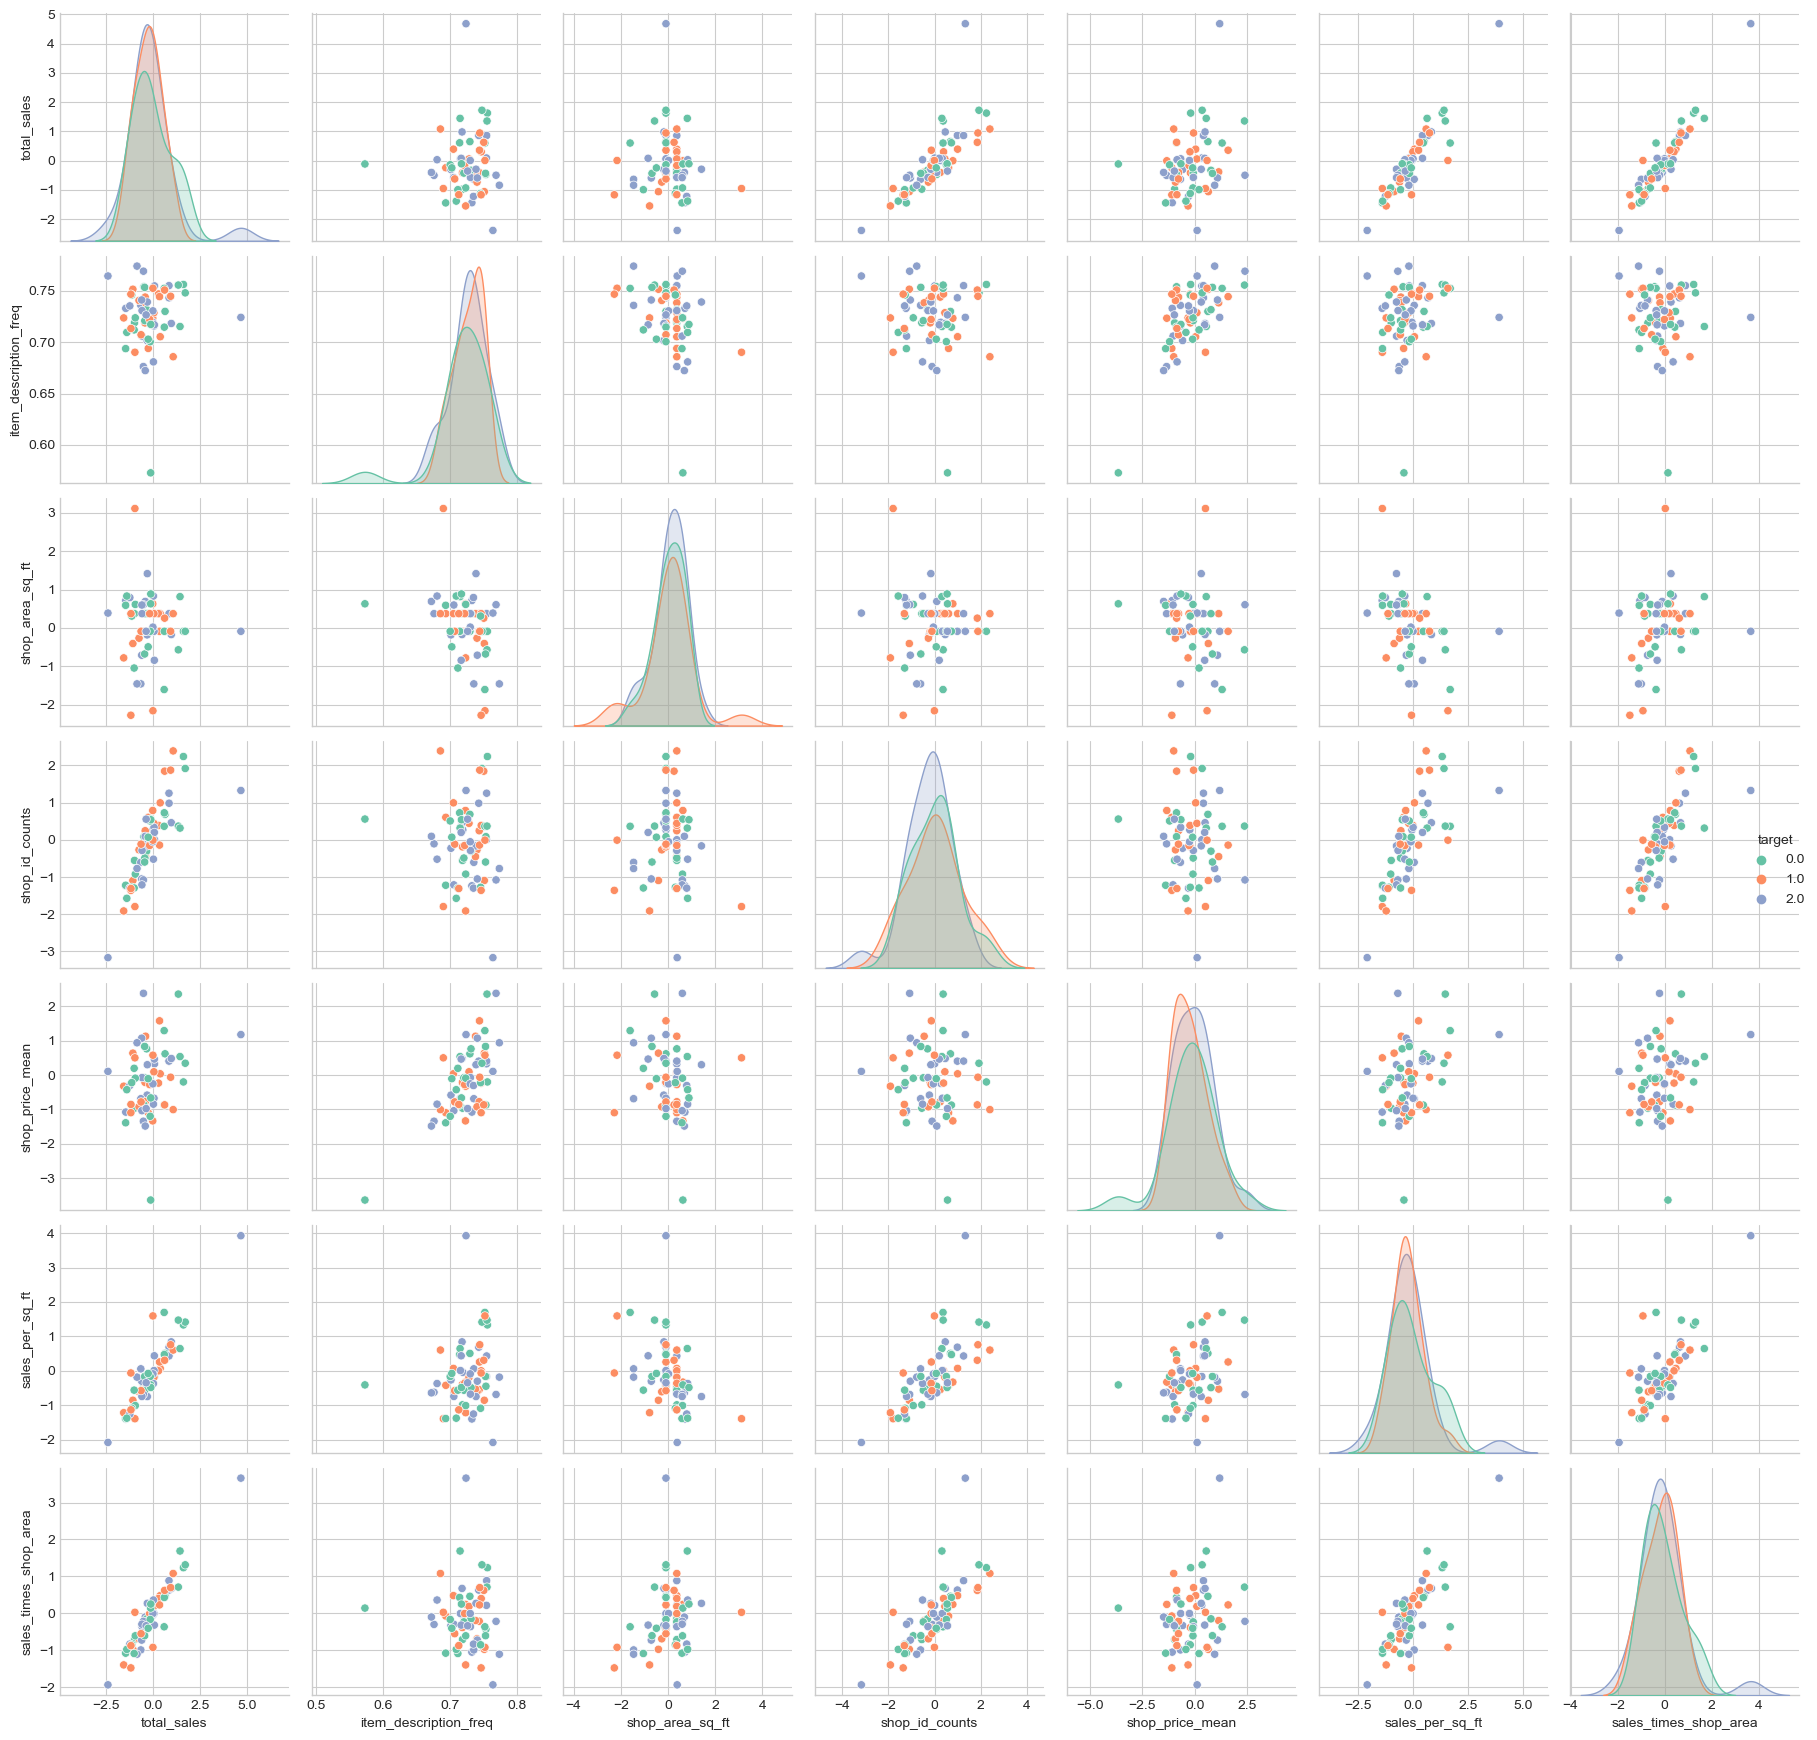

In [168]:
# Define a custom color palette
custom_palette = sns.color_palette("Set2")

# Plot the pairplot with the custom palette
sns.pairplot(df_concat, hue='target', palette=custom_palette)

# Clustering

In [169]:
from sklearn.cluster import KMeans

def cluster_labels(df, features, n_clusters=6):
  X = df.copy()
  X_new = X.loc[:, features]
  kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=0)
  X_new["Cluster"] = kmeans.fit_predict(X_new)
  X_new["Cluster"] = X_new.Cluster.astype("category")
  return X_new

In [170]:
def plot_cluster(X, y):
  Xy = X.copy()
  Xy["y"] = y
  Xy.head()
  sns.relplot(
      x="value", y="y", hue="Cluster", col="variable",
      height=4, aspect=1, facet_kws={'sharex':False}, col_wrap=3,
      data=Xy.melt(
          value_vars=features, id_vars=["y", "Cluster"]
      )
  )

In [171]:
features = X_train.columns
cluster_df1_x = cluster_labels(X_train, features, n_clusters=3)
cluster_df2_x = cluster_labels(X_test, features, n_clusters=3)
# cluster_df3_x = cluster_labels(Submission_testing, features, n_clusters=3)
cluster_df1_x.head()

,shop_id,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,sales_per_sq_ft,sales_times_shop_area,Cluster
2,55,-1.437834,0.733008,0.714516,-1.235334,-1.075963,-1.398157,-1.051007,1
73,9,-0.241329,0.693988,0.371710,0.604209,-1.095486,-0.420672,-0.072905,2
97,126,-0.304165,0.728389,-2.339571,-0.494300,-0.240830,1.364959,-1.128157,0
62,118,0.864983,0.743282,-0.087961,0.982938,0.406399,0.686772,0.630741,0
19,75,-0.002939,0.723411,0.628815,0.787776,-1.332361,-0.327605,0.242065,1


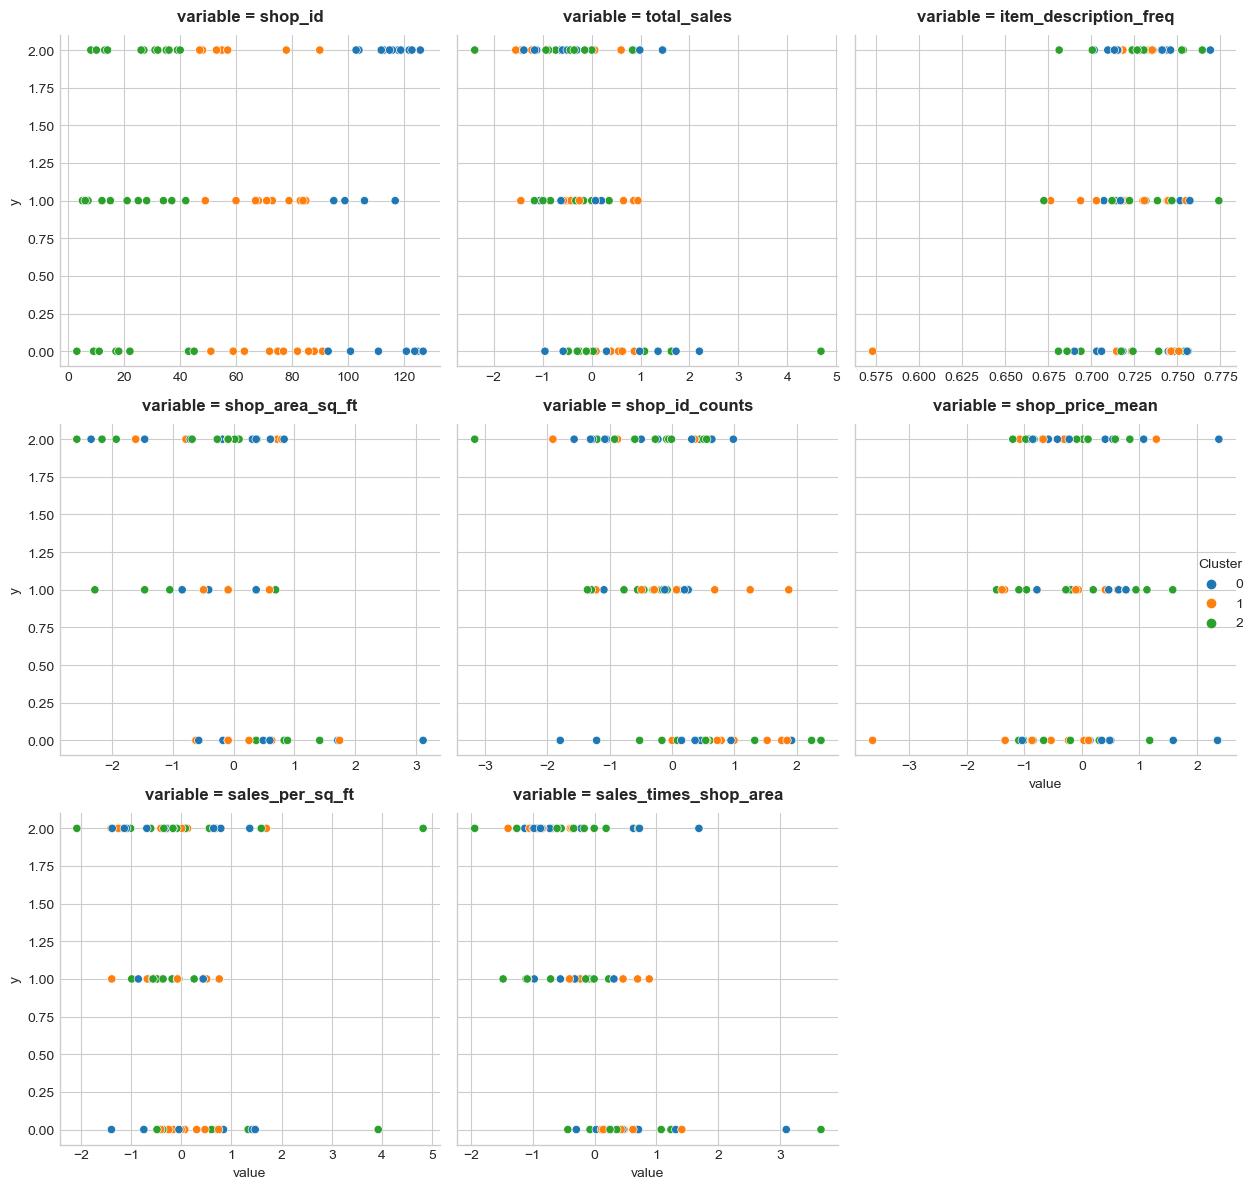

In [172]:
plot_cluster(cluster_df1_x, y_train)

In [173]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 2 to 37
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   shop_id                80 non-null     category
 1   total_sales            80 non-null     float64 
 2   item_description_freq  80 non-null     float64 
 3   shop_area_sq_ft        80 non-null     float64 
 4   shop_id_counts         80 non-null     float64 
 5   shop_price_mean        80 non-null     float64 
 6   sales_per_sq_ft        80 non-null     float64 
 7   sales_times_shop_area  80 non-null     float64 
dtypes: category(1), float64(7)
memory usage: 12.0 KB


In [174]:
score_classification(svm, cluster_df1_x, y_train, cluster_df2_x, y_test)

SVC(C=1, gamma=0.1, kernel='linear')
Accuracy: 0.5
Precision: 0.4444444444444444
Recall: 0.404040404040404
F1 Score: 0.4222222222222222


In [175]:
cluster_df1_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 2 to 37
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   shop_id                80 non-null     category
 1   total_sales            80 non-null     float64 
 2   item_description_freq  80 non-null     float64 
 3   shop_area_sq_ft        80 non-null     float64 
 4   shop_id_counts         80 non-null     float64 
 5   shop_price_mean        80 non-null     float64 
 6   sales_per_sq_ft        80 non-null     float64 
 7   sales_times_shop_area  80 non-null     float64 
 8   Cluster                80 non-null     category
dtypes: category(2), float64(7)
memory usage: 12.2 KB


In [176]:
cluster_df1_x['shop_id'] = cluster_df1_x['shop_id'].astype('float64')

In [177]:
mi_scores = make_mi_scores(cluster_df1_x, y_train)
mi_scores

sales_times_shop_area    0.183477
sales_per_sq_ft          0.156054
shop_id_counts           0.151098
shop_area_sq_ft          0.113968
total_sales              0.049087
shop_price_mean          0.045456
shop_id                  0.030198
item_description_freq    0.024278
Cluster                  0.000000
Name: Mutual Information Scores, dtype: float64

In [178]:
cluster_df1_x.drop(['shop_price_mean'], axis=1, inplace=True)
cluster_df2_x.drop(['shop_price_mean'], axis=1, inplace=True)

In [179]:
cluster_df1_x.drop(columns=['item_description_freq', 'shop_id_counts'], axis=1, inplace=True)
cluster_df2_x.drop(columns=['item_description_freq', 'shop_id_counts'], axis=1, inplace=True)

In [180]:
score_classification(svm, cluster_df1_x, y_train, cluster_df2_x, y_test)

SVC(C=1, gamma=0.1, kernel='linear')
Accuracy: 0.3
Precision: 0.38888888888888884
Recall: 0.2828282828282828
F1 Score: 0.28571428571428575


# Dimensionality Reduction

In [181]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,sales_per_sq_ft,sales_times_shop_area
total_sales,1.000000,0.003231,0.002795,0.763308,0.313654,0.823401,0.903274
item_description_freq,0.003231,1.000000,-0.264136,-0.027670,0.619900,0.098636,-0.095002
shop_area_sq_ft,0.002795,-0.264136,1.000000,0.064234,-0.129286,-0.479863,0.399571
shop_id_counts,0.763308,-0.027670,0.064234,1.000000,-0.056053,0.554202,0.720622
shop_price_mean,0.313654,0.619900,-0.129286,-0.056053,1.000000,0.338011,0.229788
sales_per_sq_ft,0.823401,0.098636,-0.479863,0.554202,0.338011,1.000000,0.515792
sales_times_shop_area,0.903274,-0.095002,0.399571,0.720622,0.229788,0.515792,1.000000


In [182]:
pca, X_pca, loadings = apply_pca(X_train_mi)
print(loadings)

                            PC1       PC2       PC3       PC4       PC5  \
shop_id                0.999980 -0.003791  0.002282  0.004614 -0.000024   
total_sales            0.002410  0.555797 -0.041964 -0.064196  0.253017   
item_description_freq -0.000017  0.000956  0.009626 -0.012931 -0.028917   
shop_area_sq_ft        0.003234 -0.039362 -0.730307 -0.351119  0.158187   
shop_id_counts         0.000657  0.472746 -0.252495  0.373791 -0.740369   
shop_price_mean        0.003630  0.158893  0.341063 -0.824346 -0.417855   
sales_per_sq_ft        0.000520  0.500311  0.413555  0.122632  0.374815   
sales_times_shop_area  0.003281  0.436439 -0.337175 -0.195194  0.216536   

                            PC6       PC7       PC8  
shop_id               -0.000180 -0.000066 -0.000057  
total_sales           -0.258563 -0.744534 -0.000075  
item_description_freq -0.001238 -0.008011 -0.999418  
shop_area_sq_ft        0.554419 -0.096719 -0.007017  
shop_id_counts         0.154294  0.029724  0.014176  


In [183]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [184]:
def create_features(df,y, df_test=None, y_test=None):
    X = df.copy()
    y = y.copy()
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        y_test = y_test.copy()
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    if df_test is not None:
        return X, X_test
    else:
        return X



In [185]:

X_train_pca, X_test_pca = create_features(X_train_mi, y_train, X_test_mi, y_test)

In [186]:
score_classification(knn, X_train_pca, y_train, X_test_pca, y_test)

KNeighborsClassifier(leaf_size=10, metric='manhattan', n_neighbors=11, p=1,
                     weights='distance')
Accuracy: 0.45
Precision: 0.4797619047619048
Recall: 0.4797979797979797
F1 Score: 0.442016317016317


In [187]:
pca, X_pca, loadings = apply_pca(X_train_mi)
print(loadings)

                            PC1       PC2       PC3       PC4       PC5  \
shop_id                0.999980 -0.003791  0.002282  0.004614 -0.000024   
total_sales            0.002410  0.555797 -0.041964 -0.064196  0.253017   
item_description_freq -0.000017  0.000956  0.009626 -0.012931 -0.028917   
shop_area_sq_ft        0.003234 -0.039362 -0.730307 -0.351119  0.158187   
shop_id_counts         0.000657  0.472746 -0.252495  0.373791 -0.740369   
shop_price_mean        0.003630  0.158893  0.341063 -0.824346 -0.417855   
sales_per_sq_ft        0.000520  0.500311  0.413555  0.122632  0.374815   
sales_times_shop_area  0.003281  0.436439 -0.337175 -0.195194  0.216536   

                            PC6       PC7       PC8  
shop_id               -0.000180 -0.000066 -0.000057  
total_sales           -0.258563 -0.744534 -0.000075  
item_description_freq -0.001238 -0.008011 -0.999418  
shop_area_sq_ft        0.554419 -0.096719 -0.007017  
shop_id_counts         0.154294  0.029724  0.014176  


In [188]:
pc1 = ['shop_id', 'total_sales', 'shop_area_sq_ft',
       'shop_id_counts', 'shop_price_mean', 'sales_per_sq_ft',
       'sales_times_shop_area']

In [189]:
X_train_pca1 = X_train[pc1]
X_test_pca1 = X_test[pc1]

In [190]:
score_classification(svm, X_train_pca1, y_train, X_test_pca1, y_test)

SVC(C=1, gamma=0.1, kernel='linear')
Accuracy: 0.55
Precision: 0.44973544973544977
Recall: 0.4343434343434343
F1 Score: 0.43846153846153846


In [191]:
outputResult(svm, scaled_X_train[pc1], y_train_main, scaled_X_submission[pc1], le)

SVC(C=1, gamma=0.1, kernel='linear')


In [192]:
X_submission = scaled_X_submission[pc1]

In [193]:
X_submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   shop_id                24 non-null     category
 1   total_sales            24 non-null     float64 
 2   shop_area_sq_ft        24 non-null     float64 
 3   shop_id_counts         24 non-null     float64 
 4   shop_price_mean        24 non-null     float64 
 5   sales_per_sq_ft        24 non-null     float64 
 6   sales_times_shop_area  24 non-null     float64 
dtypes: category(1), float64(6)
memory usage: 2.1 KB


In [194]:
outputResult(svm, X_train_pca1, y_train, X_submission, le)

SVC(C=1, gamma=0.1, kernel='linear')


In [195]:
for clf in classifiers:
    scores = cross_val_score(clf, X_train_pca1, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LogisticRegression
F1 Score: 0.57 (+/- 0.23)
DecisionTreeClassifier
F1 Score: 0.42 (+/- 0.23)
KNeighborsClassifier
F1 Score: 0.34 (+/- 0.20)
RandomForestClassifier
F1 Score: 0.57 (+/- 0.19)
GaussianNB
F1 Score: 0.52 (+/- 0.29)
SVC
F1 Score: 0.62 (+/- 0.20)
GradientBoostingClassifier
F1 Score: 0.50 (+/- 0.14)


In [196]:
score_classification(dtc, X_train_pca1, y_train, X_test_pca1, y_test)

DecisionTreeClassifier()
Accuracy: 0.35
Precision: 0.3941798941798942
Recall: 0.3434343434343434
F1 Score: 0.337037037037037


In [197]:
outputResult(rfc, X_train_pca1, y_train, X_submission, le)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10)


In [198]:
pc2 = ['shop_id', 'total_sales', 'shop_price_mean',
       'shop_id_counts', 'sales_per_sq_ft',
       'sales_times_shop_area']


In [199]:
X_train_pca2 = X_train[pc2]
X_test_pca2 = X_test[pc2]

In [200]:
score_classification(dtc, X_train_pca2, y_train, X_test_pca2, y_test)

DecisionTreeClassifier()
Accuracy: 0.35
Precision: 0.3941798941798942
Recall: 0.3434343434343434
F1 Score: 0.337037037037037


In [201]:
for clf in classifiers:
    scores = cross_val_score(clf, X_train_pca2, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LogisticRegression
F1 Score: 0.54 (+/- 0.18)
DecisionTreeClassifier
F1 Score: 0.46 (+/- 0.24)
KNeighborsClassifier
F1 Score: 0.33 (+/- 0.23)
RandomForestClassifier
F1 Score: 0.52 (+/- 0.25)
GaussianNB
F1 Score: 0.53 (+/- 0.29)
SVC
F1 Score: 0.61 (+/- 0.23)
GradientBoostingClassifier
F1 Score: 0.42 (+/- 0.15)


In [202]:
pc3 = ['shop_id', 'shop_area_sq_ft',
       'shop_id_counts', 'shop_price_mean', 'sales_per_sq_ft',
       'sales_times_shop_area']

In [203]:
X_train_pca3 = X_train[pc3]
X_test_pca3 = X_test[pc3]

In [204]:
score_classification(svm, X_train_pca3, y_train, X_test_pca3, y_test)

SVC(C=1, gamma=0.1, kernel='linear')
Accuracy: 0.55
Precision: 0.44973544973544977
Recall: 0.4343434343434343
F1 Score: 0.43846153846153846


In [205]:
for clf in classifiers:
    scores = cross_val_score(clf, X_train_pca3, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LogisticRegression
F1 Score: 0.57 (+/- 0.23)
DecisionTreeClassifier
F1 Score: 0.45 (+/- 0.26)
KNeighborsClassifier
F1 Score: 0.34 (+/- 0.22)
RandomForestClassifier
F1 Score: 0.54 (+/- 0.25)
GaussianNB
F1 Score: 0.52 (+/- 0.35)
SVC
F1 Score: 0.61 (+/- 0.27)
GradientBoostingClassifier
F1 Score: 0.45 (+/- 0.22)


## Simplified Model

In [206]:
X_train.columns

Index(['shop_id', 'total_sales', 'item_description_freq', 'shop_area_sq_ft',
       'shop_id_counts', 'shop_price_mean', 'sales_per_sq_ft',
       'sales_times_shop_area'],
      dtype='object')

In [207]:
simplified_features = ['shop_id', 'total_sales', 'shop_area_sq_ft',
       'shop_id_counts', 'shop_price_mean', 'sales_per_sq_ft',
       'sales_times_shop_area']

X_train_simple = X_train[simplified_features]
X_test_simple = X_test[simplified_features]

In [208]:
score_classification(svm, X_train_simple, y_train, X_test_simple, y_test)

SVC(C=1, gamma=0.1, kernel='linear')
Accuracy: 0.55
Precision: 0.44973544973544977
Recall: 0.4343434343434343
F1 Score: 0.43846153846153846


In [209]:
X_train.drop(columns=['shop_area_sq_ft'], axis=1, inplace=True)
X_test.drop(columns=['shop_area_sq_ft'], axis=1, inplace=True)
for clf in classifiers:
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


LogisticRegression
F1 Score: 0.56 (+/- 0.17)
DecisionTreeClassifier
F1 Score: 0.50 (+/- 0.35)
KNeighborsClassifier
F1 Score: 0.33 (+/- 0.23)
RandomForestClassifier
F1 Score: 0.53 (+/- 0.16)
GaussianNB
F1 Score: 0.50 (+/- 0.31)
SVC
F1 Score: 0.61 (+/- 0.23)
GradientBoostingClassifier
F1 Score: 0.41 (+/- 0.14)


In [210]:
score_classification(knn, X_train, y_train, X_test, y_test)

KNeighborsClassifier(leaf_size=10, metric='manhattan', n_neighbors=11, p=1,
                     weights='distance')
Accuracy: 0.5
Precision: 0.5074074074074074
Recall: 0.51010101010101
F1 Score: 0.4629629629629631


In [211]:
X_train.drop(columns=['order_count', 'unique_items'], axis=1, inplace=True)
X_test.drop(columns=['order_count', 'unique_items'], axis=1, inplace=True)


KeyError: "['order_count', 'unique_items'] not found in axis"

In [ ]:
for clf in classifiers:
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
# scaled_X_submission = scaled_X_submission[X_train.columns]
# outputResult(gbm, X_train, y_train, scaled_X_submission, le)

In [ ]:
# Define the hyperparameters to test
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}



In [ ]:
# Use grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)

In [ ]:
# rfc.set_params(**grid_search.best_params_)

In [ ]:
score_classification(rfc, X_train, y_train, X_test, y_test)

In [ ]:
# Fit the grid search object on the data
# grid_search_knn.fit(X_train, y_train)


In [ ]:

# Print the best parameters found
# print("Best parameters:", grid_search_knn.best_params_)

In [ ]:
# knn.set_params(**{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'})
knn.set_params(**{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'})


In [ ]:
X_train.head()

In [ ]:
score_classification(dtc, X_train, y_train, X_test, y_test)

In [ ]:
score_classification(knn, X_train, y_train, X_test, y_test)

In [ ]:
score_classification(nb, X_train, y_train, X_test, y_test)

In [ ]:
score_classification(dtc, X_train, y_train, X_test, y_test)

In [ ]:
scaled_X_submission = scaled_X_submission[X_train.columns]

In [ ]:
outputResult(knn, X_train, y_train, scaled_X_submission, le)